In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
#Load Dataset
dataset = pd.read_csv('./wineNew.csv')
dataset.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
#Set x and y variable
x = dataset.values

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(x)
data_transformed=sc.transform(x)

In [4]:
# Determine Number of Components for DR
from sklearn.decomposition import PCA

#PCA Ratios
pca_none = PCA(n_components=None,random_state=100)
X_pca = pca_none.fit(data_transformed, y=None)
pca_var_ratios = pca_none.explained_variance_ratio_

# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

#Number of components
n_comppca=select_n_components(pca_var_ratios, 0.95)

#Reduced Data
reduced_data = PCA(n_components=n_comppca,random_state=100).fit_transform(data_transformed)

In [5]:
#Optimized Number of Cluster and Associated Silhouette Coefficient - Kmeans

# Set initial silhouette score
sil_score = [0]
k_value = [0]

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster,random_state=100).fit(reduced_data)
    label = kmeans.labels_
    sil_coeff = silhouette_score(data_transformed, label, metric='euclidean')

    # If statement to find optimal Silhouette Score
    if sil_score <= sil_coeff:
        
        # Add Optimal Silhouette Coefficient and K-Value
        sil_score.clear()
        k_value.clear()
        sil_score.append(float(sil_coeff))
        k_value.append(float(n_cluster)) 
        
opt_clusters = int(np.asarray(k_value))
opt_silscore = float(np.asarray(sil_score))
print('Optimized n_clusters= {}, Silhouette Coefficient is {:.2f}'.format(opt_clusters, opt_silscore))
print('\nNumber of Components Used:', n_comppca)

Optimized n_clusters= 3, Silhouette Coefficient is 0.28

Number of Components Used: 10


In [6]:
#Create KMeans with Identified Clusters
kmeans = KMeans(n_clusters = opt_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 100)
y_kmeans = kmeans.fit_predict(x)

#Create Revised Dataset
dataset2=dataset
dataset2['Clust-KM'] = y_kmeans
dataset2['Clust-KM'] = dataset2['Clust-KM'].map({0:'Cluster 1', 1:'Cluster 2',2:'Cluster 3'}) 
dataset2.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Clust-KM
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,Cluster 2
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,Cluster 2
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,Cluster 2
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,Cluster 2
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,Cluster 3


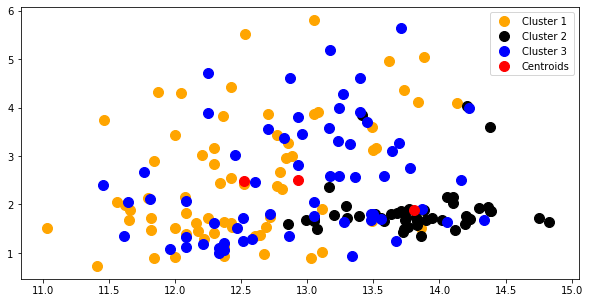

In [7]:
#Plot of Clusters
fig = plt.figure(figsize=(10,5))
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'orange', label = 'Cluster 1')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'black', label = 'Cluster 2')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'blue', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')
plt.legend()

In [8]:
#Optimized Number of Cluster and Associated Silhouette Coefficient - GMM

# Set initial silhouette score
sil_scoregmm = [0]
k_valuegmm = [0]

for n_clustergmm in range(2, 10):
    gmm = GaussianMixture(n_components=n_clustergmm,random_state=100).fit_predict(reduced_data)
    labelgmm = gmm
    sil_coeffgmm = silhouette_score(data_transformed, labelgmm, metric='euclidean')

    # If statement to find optimal Silhouette Score
    if sil_scoregmm <= sil_coeffgmm:
        
        # Add Optimal Silhouette Coefficient and K-Value
        sil_scoregmm.clear()
        k_valuegmm.clear()
        sil_scoregmm.append(float(sil_coeffgmm))
        k_valuegmm.append(float(n_clustergmm)) 
        
opt_clustersgmm = int(np.asarray(k_valuegmm))
opt_silscoregmm = float(np.asarray(sil_scoregmm))
print('Optimized n_components= {}, Silhouette Coefficient is {:.2f}'.format(opt_clustersgmm, opt_silscoregmm))
print('\nNumber of Components Used:', n_comppca)

Optimized n_components= 3, Silhouette Coefficient is 0.28

Number of Components Used: 10


In [9]:
#Gaussian Mixture Model (GMM) Clustering
gmm = GaussianMixture(n_components=opt_clustersgmm,random_state=100)
y_gmm = gmm.fit_predict(x)

#Create Revised Dataset
dataset3=dataset
dataset3['Clust-GMM'] = y_gmm
dataset3['Clust-GMM'] = dataset3['Clust-GMM'].map({0:'Cluster 1', 1:'Cluster 2',2:'Cluster 3'}) 
dataset3.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Clust-KM,Clust-GMM
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,Cluster 2,Cluster 1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,Cluster 2,Cluster 3
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,Cluster 2,Cluster 3
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,Cluster 2,Cluster 3
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,Cluster 3,Cluster 1


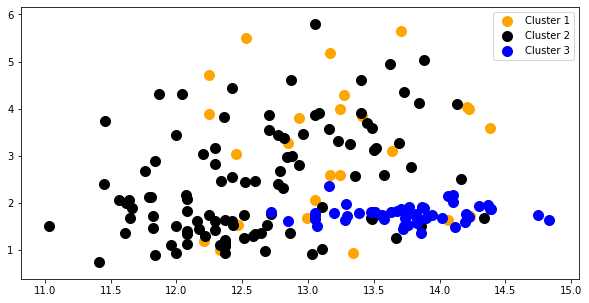

In [10]:
#Plot of Clusters
fig = plt.figure(figsize=(10,5))
plt.scatter(x[y_gmm == 0, 0], x[y_gmm == 0, 1], s = 100, c = 'orange', label = 'Cluster 1')
plt.scatter(x[y_gmm == 1, 0], x[y_gmm == 1, 1], s = 100, c = 'black', label = 'Cluster 2')
plt.scatter(x[y_gmm == 2, 0], x[y_gmm == 2, 1], s = 100, c = 'blue', label = 'Cluster 3')
plt.legend()